In [1]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [3]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [4]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
# df_train, df_test = merge_new_feature("../input/feature_categorical_rete__by__categorical_count.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [5]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [6]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【card_id_count】
0.9935317230513652



【hist_authorized_flag_sum】 --- 【authorized_flag_ture】
0.9979558326172671



【hist_authorized_flag_sum】 --- 【authorized_flag_ture_weighted_elapsed】
0.9979558326172671



【hist_authorized_flag_mean】 --- 【authorized_flag_ture_rate】
0.9871399739794636



【hist_category_1_sum】 --- 【category_1_true】
0.9996032083806138



【hist_category_1_sum】 --- 【category_1_true_weighted_elapsed】
0.9996032083806138



【hist_category_1_mean】 --- 【category_1_true_rate】
0.9915584786977886



【hist_card_id_size】 --- 【card_id_count】
0.9981205383400666



【hist_card_id_size】 --- 【authorized_flag_ture】
0.991907744189161



【hist_card_id_size】 --- 【authorized_flag_ture_weighted_elapsed】
0.991907744189161



【hist_purchase_date_diff】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min

In [7]:
sorted(set(drop_col))

['authorized_flag_ture',
 'authorized_flag_ture_rate',
 'authorized_flag_ture_weighted_elapsed',
 'card_id_count',
 'category_1_true',
 'category_1_true_rate',
 'category_1_true_weighted_elapsed',
 'category_3_A_latest_trs',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'hist_card_id_size',
 'installments_0',
 'installments_0_rate',
 'installments_0_weighted_elapsed',
 'installments_1',
 'installments_1_rate',
 'installments_1_weighted_elapsed',
 'month_lag_N10_weighted_elapsed',
 'month_lag_N11_weighted_elapsed',
 'month_lag_N12_weighted_elapsed',
 'month_lag_N13_weighted_elapsed',
 'month_lag_N8_weighted_elapsed',
 'month_lag_N9_weighted_elapsed',
 'most_recent_purchases_range_null_latest_trs',
 'most_recent_sales_range_null_latest_trs',
 'new_hist_purchase_date_min',
 'numerical_1_null_latest_trs']

In [8]:
len(df_train_columns)

274

In [9]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.908207	valid_1's auc: 0.894438
[200]	training's auc: 0.926521	valid_1's auc: 0.901592
[300]	training's auc: 0.937438	valid_1's auc: 0.904107
[400]	training's auc: 0.947517	valid_1's auc: 0.905555
[500]	training's auc: 0.956537	valid_1's auc: 0.906918
[600]	training's auc: 0.963981	valid_1's auc: 0.906974
[700]	training's auc: 0.969859	valid_1's auc: 0.90669
[800]	training's auc: 0.974225	valid_1's auc: 0.90599
[900]	training's auc: 0.977673	valid_1's auc: 0.90542
Early stopping, best iteration is:
[526]	training's auc: 0.958617	valid_1's auc: 0.907051
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.912468	valid_1's auc: 0.883722
[200]	training's auc: 0.928517	valid_1's auc: 0.88789
[300]	training's auc: 0.939636	valid_1's auc: 0.891455
[400]	training's auc: 0.949979	valid_1's auc: 0.893502
[500]	training's auc: 0.957314	valid_1's auc: 0.894746
[600

0.9008719439744041

0.8805100268066539

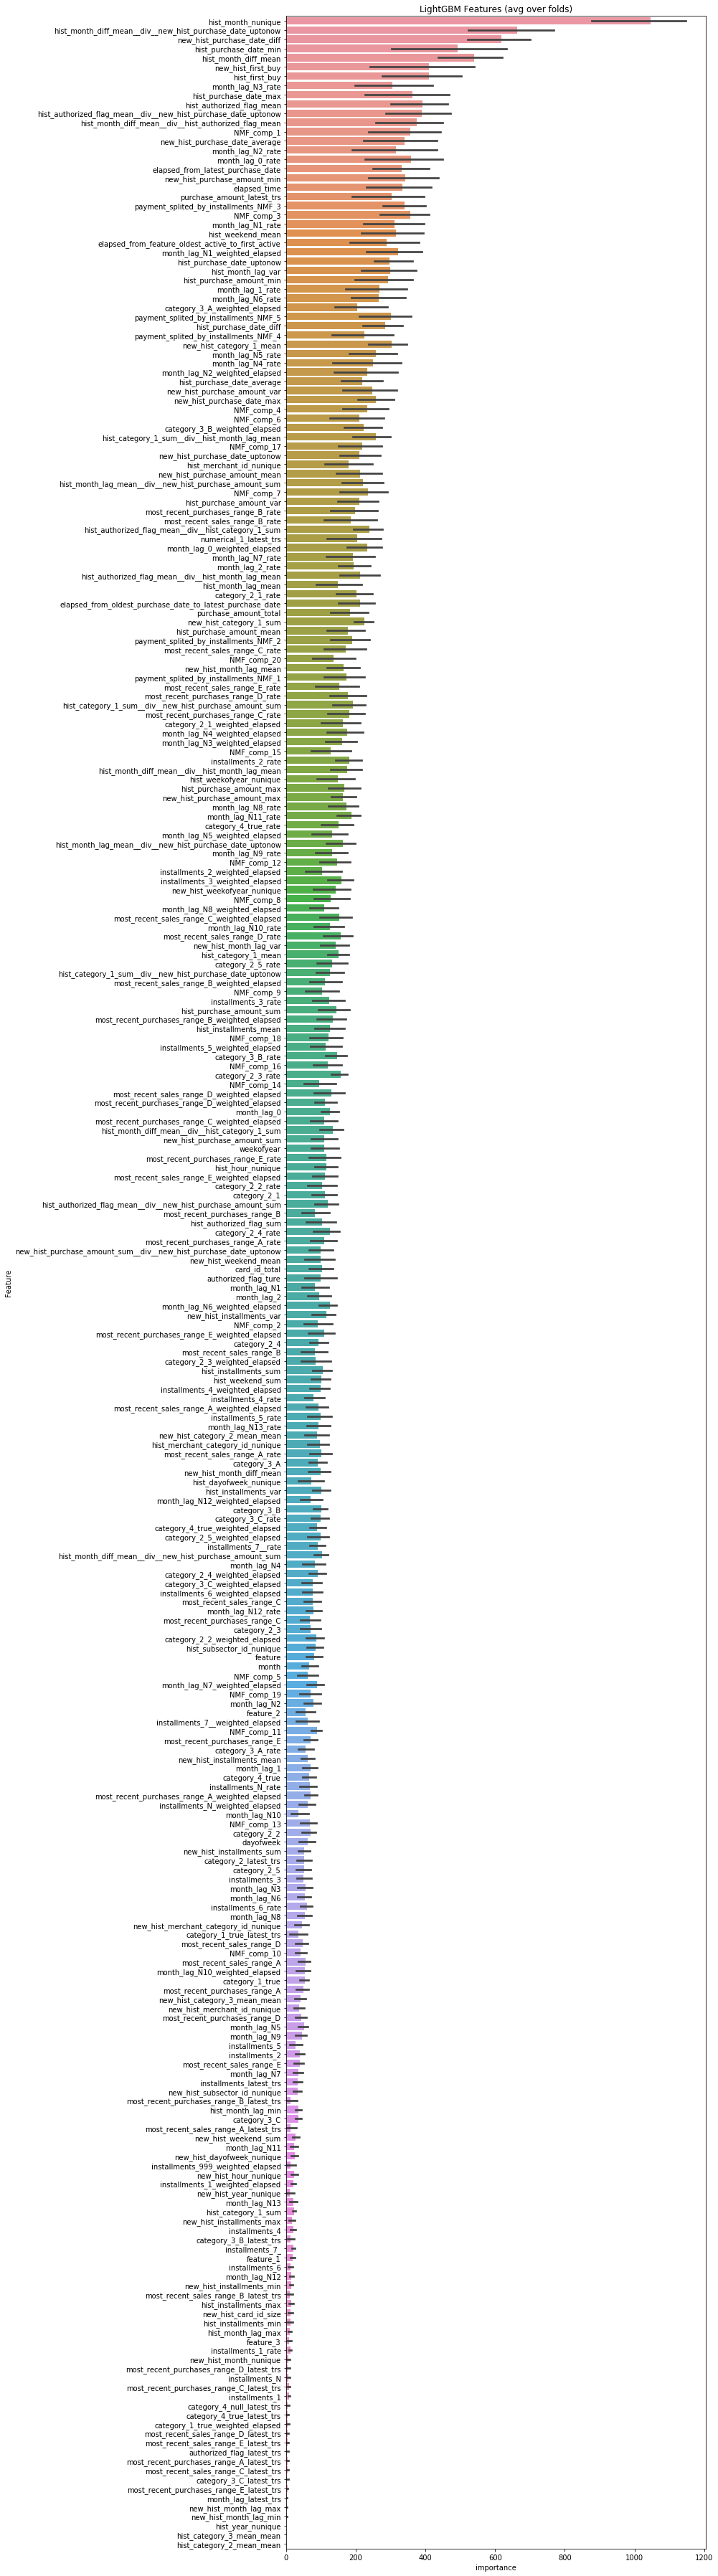

In [10]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

0.626<br>
3.869852853047011

In [11]:
df_train_columns2 = cols[:200]

#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target_outlier.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target_outlier.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target_outlier, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.908555	valid_1's auc: 0.895387
[200]	training's auc: 0.927373	valid_1's auc: 0.901096
[300]	training's auc: 0.938404	valid_1's auc: 0.903907
[400]	training's auc: 0.947892	valid_1's auc: 0.904927
[500]	training's auc: 0.956504	valid_1's auc: 0.905784
[600]	training's auc: 0.964455	valid_1's auc: 0.906008
[700]	training's auc: 0.970157	valid_1's auc: 0.905753
[800]	training's auc: 0.974518	valid_1's auc: 0.905147
[900]	training's auc: 0.977844	valid_1's auc: 0.904831
Early stopping, best iteration is:
[581]	training's auc: 0.962894	valid_1's auc: 0.906139
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.911659	valid_1's auc: 0.884268
[200]	training's auc: 0.929203	valid_1's auc: 0.888425
[300]	training's auc: 0.939579	valid_1's auc: 0.89163
[400]	training's auc: 0.949628	valid_1's auc: 0.893628
[500]	training's auc: 0.957208	valid_1's auc: 0.894877
[

0.9011876418813624

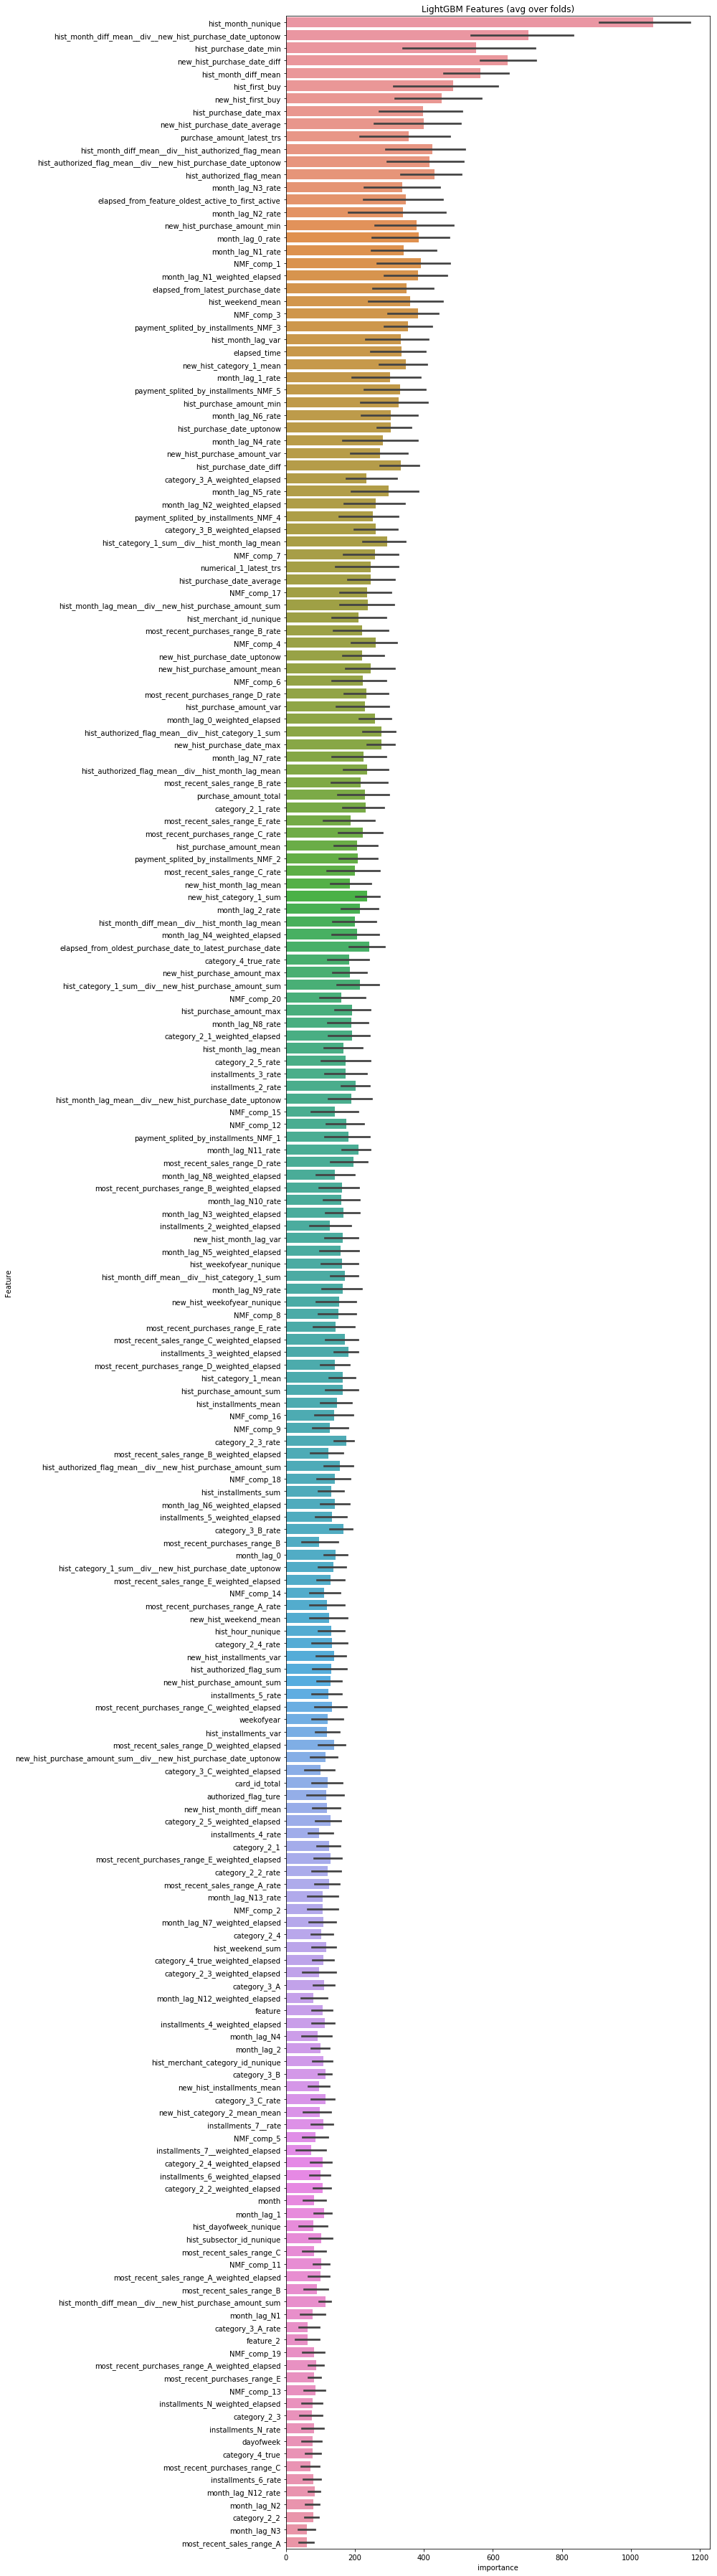

In [12]:
cols2 = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols2)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [13]:
for k in range(-30, 0, 1):
    rmse = []
    for i in [i/1000.0 for i in range(1,1001)]:
        predict_outliers = np.where(oof>i, k, 0)
        rmse.append(np.sqrt(mean_squared_error(target.values, predict_outliers)))
        if min(rmse) == rmse[-1]:
            best_th = i
    print("%d -- %f -- %f" %(k, min(rmse), best_th))

-30 -- 3.856198 -- 0.452000
-29 -- 3.855653 -- 0.452000
-28 -- 3.855120 -- 0.446000
-27 -- 3.854597 -- 0.446000
-26 -- 3.854029 -- 0.397000
-25 -- 3.852803 -- 0.397000
-24 -- 3.851082 -- 0.333000
-23 -- 3.848167 -- 0.333000
-22 -- 3.845575 -- 0.333000
-21 -- 3.842761 -- 0.313000
-20 -- 3.837410 -- 0.258000
-19 -- 3.831410 -- 0.249000
-18 -- 3.825566 -- 0.249000
-17 -- 3.820594 -- 0.249000
-16 -- 3.815319 -- 0.217000
-15 -- 3.809133 -- 0.217000
-14 -- 3.803511 -- 0.187000
-13 -- 3.796749 -- 0.187000
-12 -- 3.791765 -- 0.187000
-11 -- 3.784263 -- 0.136000
-10 -- 3.776921 -- 0.133000
-9 -- 3.772404 -- 0.132000
-8 -- 3.769389 -- 0.106000
-7 -- 3.764539 -- 0.090000
-6 -- 3.763736 -- 0.090000
-5 -- 3.765223 -- 0.077000
-4 -- 3.770118 -- 0.046000
-3 -- 3.774036 -- 0.038000
-2 -- 3.786072 -- 0.028000
-1 -- 3.815488 -- 0.012000


In [28]:
df_predict = pd.read_csv("../output/submission_model20181216.csv")

In [29]:
outliers_idx = np.where(predictions>0.4)[0]

In [30]:
outliers_idx.shape

(63,)

In [31]:
df_predict["target"].iloc[outliers_idx] = -25

In [32]:
df_predict.target.describe()

count    123623.000000
mean         -0.338549
std           1.327491
min         -25.000000
25%          -0.654177
50%          -0.214496
75%           0.245404
max           5.175462
Name: target, dtype: float64

In [33]:
df_predict

,card_id,target
0,C_ID_0ab67a22ab,-2.041275
1,C_ID_130fd0cbdd,-0.305701
2,C_ID_b709037bc5,-0.974894
3,C_ID_d27d835a9f,-0.090633
4,C_ID_2b5e3df5c2,-1.465622
5,C_ID_5814b4f13c,0.587211
6,C_ID_a1b3c75277,0.161340
7,C_ID_f7cada36d3,0.836225
8,C_ID_9d2bc8dfc4,-0.709276
9,C_ID_6d8dba8475,-1.145146


In [34]:
df_predict[["card_id", "target"]].to_csv("../output/submission_model20190110.csv", index=False)